**1. Importing Libraries.**

In [7]:
import numpy as np
import pandas as pd
import librosa
import glob
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense , LSTM , Dropout , Softmax , LayerNormalization , Conv2D , MaxPool2D , Flatten , BatchNormalization
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random

**2. Analyzing the mean length of audio files in the data.**

In [8]:
def mean_audio_length():
    """
    This function finds the mean length of all the audios.
    """
    # Creating an empty list to store the lengths of each audio file
    audio_length = []
    
    # Creating a list of class names
    classes = ['Aditya', 'Mehul', 'Neha', 'Saurabh', 'Varad']
    
    # Iterating over each class
    for i in classes:
        # Creating a file path string that includes the class name
        audio_path = '/content/drive/MyDrive/VCV_Sentences/' + str(i) + '/*'
      
        
        # Using glob to find all audio files that match the file path pattern
        audio_files = glob.glob(audio_path)
    
        
        # Iterating over each audio file in the list of matching files
        for j in range(len(audio_files)):
            # Loading the audio file into a NumPy array using librosa
            audio , sr = librosa.load(audio_files[j])
            
            # Appending the length of the audio file to the list of audio lengths
            audio_length.append(len(audio))
            # print(audio_length)
            
            # Optional: Printing the length of each audio file as it's processed
            # print(len(audio))
    
    # Calculate the mean length of" all audio files in the list
    return np.mean(audio_length)

In [9]:
mean_length = mean_audio_length()
print("Mean length of all the collected audios is :", mean_length)

Mean length of all the collected audios is : 34662.933333333334


**3. Preparing the Noisy Training and Testing Data for the KNN Model.**

In [10]:
def audio_data_knn(mean_length, noise_level):
  # Create empty dictionaries to store the training and testing data
  data_train = {'labels':[],
                'mfcc':[]}
  data_test = {'labels':[],
                'mfcc':[]}
  
  # Define a list of class names
  classes = ['Aditya', 'Mehul', 'Neha', 'Saurabh', 'Varad']
  
  # Loop over each class
  for i in classes:
      # Set the path to the directory containing the audio files for this class
      audio_path = '/content/drive/MyDrive/Non_VCV_Sentences/' + str(i) + '/*'
      # Use the glob function to get a list of audio files in the directory
      audio_files = glob.glob(audio_path)
      # Loop over all audio files except the last one (used for testing)
      for j in range(len(audio_files)-2):
        # Load the audio file using librosa
        audio,sr = librosa.load(audio_files[j])
        # If the audio file is longer than the mean length, truncate it
        if len(audio)>mean_length:
          audio = audio[0:int(mean_length)]
        # If the audio file is shorter than the mean length, pad it with zeros
        if len(audio)<mean_length:
          diff = int(mean_length) - len(audio)
          audio = np.pad(audio,(0,diff))
        # Add white noise to the audio file
        noise = np.random.normal(0, noise_level, len(audio))
        audio = audio + noise
        # Compute the MFCC features for the audio file
        mfcc = librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=8)
        # Add the MFCC features and label to the training data dictionary
        data_train['mfcc'].append(mfcc.flatten())
        data_train['labels'].append(i)
      # Load the last 2 audio file in the directory (used for testing)
      for k in range(len(audio_files)-1,len(audio_files)):
        audio,sr = librosa.load(audio_files[k])
        # If the audio file is longer than the mean length, truncate it
        if len(audio)>mean_length:
          audio = audio[0:int(mean_length)]
        # If the audio file is shorter than the mean length, pad it with zeros
        if len(audio)<mean_length:
          diff = int(mean_length) - len(audio)
          audio = np.pad(audio,(0,diff))
        # Add white noise to the audio file
        noise = np.random.normal(0, noise_level, len(audio))
        audio = audio + noise
        # Compute the MFCC features for the audio file
        mfcc = librosa.feature.mfcc(y=audio,sr=sr,n_mfcc = 8)
        # Add the MFCC features and label to the testing data dictionary
        data_test['mfcc'].append(mfcc.flatten())
        data_test['labels'].append(i)
  # Return the training and testing data dictionaries
  return data_train,data_test


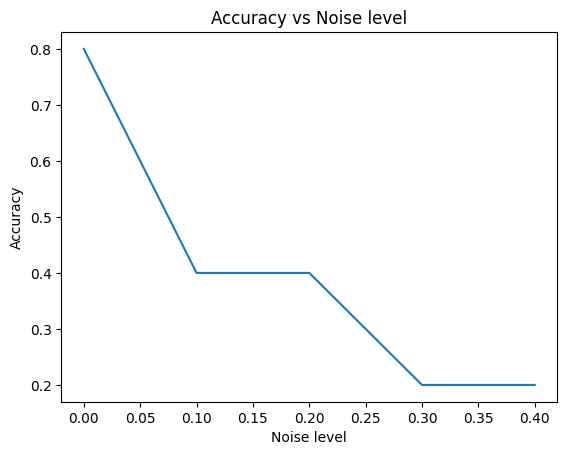

In [18]:
# Define a list of noise levels to test
noise_levels = [0, 0.1, 0.2, 0.3, 0.4]

# Create empty lists to store the accuracy and noise level data
accuracies = []
noise_levels_data = []

# Loop over each noise level
for noise_level in noise_levels:
    # Call the audio_data_knn function with the mean_length and noise_level arguments to get the training and testing data.
    knn_train_data, knn_test_data = audio_data_knn(mean_length, noise_level)
    X_knn_train = knn_train_data['mfcc']
    X_knn_test = knn_test_data['mfcc']
    y_knn_train = knn_train_data['labels']
    y_knn_test = knn_test_data['labels']
    # Ensuring that all sequences in the dataset have the same length
    X_knn_train = tf.keras.preprocessing.sequence.pad_sequences(X_knn_train)
    X_knn_test = tf.keras.preprocessing.sequence.pad_sequences(X_knn_test)
    mapping = {'Aditya':0,'Mehul':1 ,'Neha':2,'Saurabh':3,'Varad':4}

    # convert y_knn_train to a Pandas DataFrame and assign it to y_knn_train
    y_knn_train = pd.DataFrame(y_knn_train)

    # replace the values in y_knn_train using the provided mapping dictionary and assign it to y_knn_train
    y_knn_train = y_knn_train.replace(mapping)

    # convert y_knn_train to a numpy array and assign it back to y_knn_train
    y_knn_train = np.array(y_knn_train)

    # convert y_knn_test to a Pandas DataFrame and assign it to y_knn_test
    y_knn_test = pd.DataFrame(y_knn_test)

    # replace the values in y_knn_test using the provided mapping dictionary and assign it to y_knn_test
    y_knn_test = y_knn_test.replace(mapping)

    # convert y_knn_test to a numpy array and assign it back to y_knn_test
    y_knn_test = np.array(y_knn_test)

    # create a KNeighborsClassifier object with 2 neighbors and assign it to knn_classifier
    knn_classifier = KNeighborsClassifier(n_neighbors= 5 )

    # fit the knn_classifier on the training data X_knn_train and y_knn_train
    knn_classifier.fit(X_knn_train, y_knn_train.reshape(-1))

    # calculate the accuracy of the knn_classifier on the test data and append it to the accuracies list
    accuracy = knn_classifier.score(X_knn_test, y_knn_test)
    accuracies.append(accuracy)

    # append the noise level to the noise_levels_data list
    noise_levels_data.append(noise_level)

# Plot the accuracy vs noise curve
plt.plot(noise_levels_data, accuracies)
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Noise level')
plt.show()

**3. Preparing the Noisy Training and Testing Data for the CNN Model.**

In [19]:
def audio_data(mean_length, noise_level):

  """
  This function takes the mean audio length of all data, adds noise to the audio files, 
  and returns the train and test data. 

  """
  
  # Creating two empty dictionaries for training and testing data with 'labels' and 'mfcc' keys
  data_train = {'labels':[],'mfcc':[]}
  data_test = {'labels':[],'mfcc':[]}
  
  # Defining a list of class names
  classes = ['Aditya', 'Mehul', 'Neha', 'Saurabh', 'Varad']
  
  # Looping through each class
  for i in classes:
    
    # Creating a string of file paths for each class
    audio_path = '/content/drive/MyDrive/VCV_Sentences/' + str(i) + '/*'
    
    # Getting a list of all audio files in the directory
    audio_files = glob.glob(audio_path)
    
    # Looping through each audio file except for the last one (which will be used for testing)
    for j in range(len(audio_files)-2):
      
      # Loading the audio file using librosa library and its corresponding sample rate
      audio,sr = librosa.load(audio_files[j])
      
      # Adding noise to the audio signal
      noise = np.random.normal(0, noise_level, len(audio))
      audio = audio + noise
      
      # If the audio is longer than the mean_length, then trimming it
      if len(audio)>mean_length:
        audio = audio[0:int(mean_length)]
        
      # If the audio is shorter than the mean_length, then padding it with zeros
      if len(audio)<mean_length:
        diff = int(mean_length) - len(audio)
        audio = np.pad(audio,(0,diff))
      
      # Computing the MFCC features of the audio signal
      mfcc = librosa.feature.mfcc(y=audio,sr=sr)
      
      # Appending the MFCC features and the corresponding label to the training data dictionary
      data_train['mfcc'].append(mfcc.T)
      data_train['labels'].append(i)
      
    # Loading the last audio file in the directory for testing
    for k in range(len(audio_files)-2,len(audio_files)):
      
      # Loading the audio file using librosa library and its corresponding sample rate
      audio,sr = librosa.load(audio_files[k])
      
      # Adding noise to the audio signal
      noise = np.random.normal(0, noise_level, len(audio))
      audio = audio + noise
      
      # If the audio is longer than the mean_length, then trimming it
      if len(audio)>mean_length:
        audio = audio[0:int(mean_length)]
        
      # If the audio is shorter than the mean_length, then padding it with zeros
      if len(audio)<mean_length:
        diff = int(mean_length) - len(audio)
        audio = np.pad(audio,(0,diff))
      
      # Computing the MFCC features of the audio signal
      mfcc = librosa.feature.mfcc(y=audio,sr=sr)
      
      # Appending the MFCC features and the corresponding label to the testing data dictionary
      data_test['mfcc'].append(mfcc.T)
      data_test['labels'].append(i)
  
  # Returning the training and testing data dictionaries
  return data_train, data_test

In [20]:
def build_model(input_shape):
    """
    Builds a Convolutional Neural Network model using TensorFlow and Keras.

    Args:
        input_shape: A tuple of integers representing the shape of the input data.

    Returns:
        model: A compiled CNN model using the input shape.
    """

    # Creating a Sequential model
    model = tf.keras.Sequential()

    # Adding Conv2D layer with 8 filters and kernel size of (2,2) with relu activation function
    # and the input shape
    model.add(Conv2D(8, kernel_size=(2, 2), activation='relu', input_shape=input_shape))

    # Adding MaxPooling2D layer
    model.add(MaxPool2D())

    # Adding BatchNormalization layer
    model.add(BatchNormalization())

    # Adding Conv2D layer with 4 filters and kernel size of (2,2) with relu activation function
    model.add(Conv2D(4, kernel_size=(2, 2), activation='relu'))

    # Adding MaxPooling2D layer
    model.add(MaxPool2D())

    # Adding Flatten layer
    model.add(Flatten())

    # Adding Dense layer with 5 output units
    model.add(Dense(5))

    # Adding Softmax activation function to the last Dense layer
    model.add(Softmax(axis=1))

    # Compiling the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/30
13/13 [==============================] - 1s 7ms/step - loss: 2.0337 - accuracy: 0.2308
Epoch 2/30
13/13 [==============================] - 0s 6ms/step - loss: 1.6638 - accuracy: 0.2769
Epoch 3/30
13/13 [==============================] - 0s 6ms/step - loss: 1.4844 - accuracy: 0.3231
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 1.4253 - accuracy: 0.3846
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 1.3711 - accuracy: 0.3846
Epoch 6/30
13/13 [==============================] - 0s 7ms/step - loss: 1.2845 - accuracy: 0.4769
Epoch 7/30
13/13 [==============================] - 0s 6ms/step - loss: 1.2338 - accuracy: 0.4923
Epoch 8/30
13/13 [==============================] - 0s 6ms/step - loss: 1.1975 - accuracy: 0.4769
Epoch 9/30
13/13 [==============================] - 0s 7ms/step - loss: 1.1480 - accuracy: 0.6154
Epoch 10/30
13/13 [==============================] - 0s 6ms/step - loss: 1.0793 - accuracy: 0.6154
Epoch 11/30
13/13 [

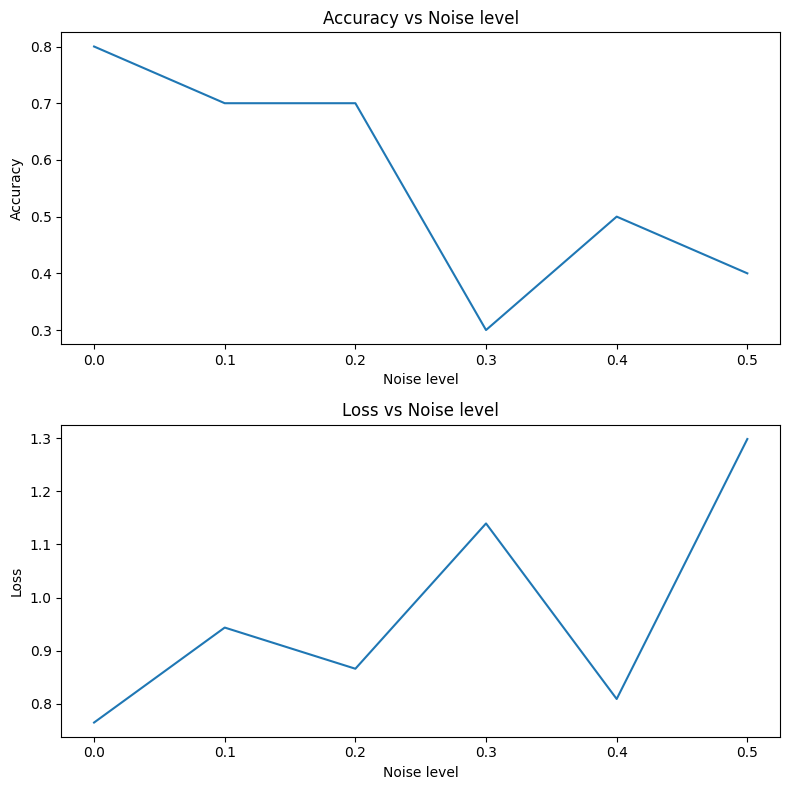

In [26]:
# Define a list of noise levels to iterate over
noise_levels = [0 , 0.1, 0.2, 0.3, 0.4, 0.5]

# Define an empty list to store the accuracies for each noise level
accuracies = []
losses = []

for noise in noise_levels:

    # Storing the obtained train and test data with added noise
    train_data , test_data = audio_data(mean_length, noise_level=noise)

    X_train = train_data['mfcc']
    y_train = train_data['labels']
    X_test = test_data['mfcc']
    y_test = test_data['labels']

    # Ensuring that all sequences in the dataset have the same length
    # Padding the sequences in X_train to a maximum length of 44
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=44)

    # Padding the sequences in X_test to a maximum length of 44
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=44)

    # preprocessing step where categorical labels are mapped to numerical values, so that they can be used as inputs to the model.
    mapping = {'Aditya':0,'Mehul':1 ,'Neha':2,'Saurabh':3,'Varad':4}   # creating a dictionary that maps class names to integers

    y_train = pd.DataFrame(y_train)    # converting y_train to a pandas dataframe
    y_train = y_train.replace(mapping)    # replacing the class names in y_train with their integer mappings
    y_train = np.array(y_train)    # converting y_train to a numpy array

    y_test = pd.DataFrame(y_test)    # converting y_test to a pandas dataframe
    y_test = y_test.replace(mapping)    # replacing the class names in y_test with their integer mappings
    y_test = np.array(y_test)    # converting y_test to a numpy array

    # Reshaping the training audio data to have 4 dimensions: batch size, audio samples, audio channels, and time steps
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

    # Getting the shape of the first audio clip in the training data
    input_shape = X_train[0].shape

    # Reshaping the testing audio data to have 4 dimensions: batch size, audio samples, audio channels, and time steps
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

    # Building the CNN model using the input shape
    model = build_model(input_shape)

    # Defining the Adam optimizer with a learning rate of 0.001
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

    # Compiling the model with the Adam optimizer, sparse categorical crossentropy loss function, and accuracy metric
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Training the model on the training data using a batch size of 5, 30 epochs, and shuffling the data before each epoch
    history = model.fit(X_train, y_train, batch_size= 5 , epochs = 30 , shuffle = True)

    test_loss, test_acc = model.evaluate(X_test, y_test)

    accuracies.append(test_acc)
    losses.append(test_loss)

# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot the accuracy vs noise curve on the first subplot
axs[0].plot(noise_levels, accuracies)
axs[0].set_xlabel('Noise level')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Noise level')

# Plot the loss vs noise curve on the second subplot
axs[1].plot(noise_levels, losses)
axs[1].set_xlabel('Noise level')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss vs Noise level')

# Display the plot
plt.tight_layout()
plt.show()

**4. Building a LSTM Model with Noisy Dataset.**

In [28]:
def build_model2(input_shape):
  """
  This function defines and returns a Sequential model for training and testing on a given dataset.
  It uses two LSTM layers with dropout and layer normalization, followed by two Dense layers and a Softmax output layer.

  Args:
  input_shape: A tuple representing the shape of the input data. It should have the format (timesteps, features).

  Returns:
  A Keras Sequential model with the specified architecture.

  """
  
  # Defining the Sequential model
  model = tf.keras.Sequential()
  
  # Adding the first LSTM layer with 128 units, input shape, and return sequences
  model.add(LSTM(128,input_shape = input_shape,return_sequences=True))
  
  # Adding a Dropout layer with a rate of 0.4
  model.add(Dropout(0.4))
  
  # Adding a LayerNormalization layer
  model.add(LayerNormalization())
  
  # Adding the second LSTM layer with 64 units
  model.add(LSTM(64))
  
  # Adding a Dense layer with 32 units
  model.add(Dense(32))
  
  # Adding a second Dense layer with 2 units for the output
  model.add(Dense(5))
  
  # Adding a Softmax activation function to the output layer
  model.add(Softmax(axis=1))
  
  # Returning the completed model
  return model

Epoch 1/10
13/13 [==============================] - 7s 256ms/step - loss: 1.6538 - accuracy: 0.1231
Epoch 2/10
13/13 [==============================] - 4s 323ms/step - loss: 1.3783 - accuracy: 0.4615
Epoch 3/10
13/13 [==============================] - 3s 235ms/step - loss: 0.9992 - accuracy: 0.7846
Epoch 4/10
13/13 [==============================] - 3s 235ms/step - loss: 0.5806 - accuracy: 0.8923
Epoch 5/10
13/13 [==============================] - 3s 231ms/step - loss: 0.2127 - accuracy: 0.9692
Epoch 6/10
13/13 [==============================] - 4s 344ms/step - loss: 0.1068 - accuracy: 0.9846
Epoch 7/10
13/13 [==============================] - 4s 280ms/step - loss: 0.1051 - accuracy: 0.9692
Epoch 8/10
13/13 [==============================] - 3s 231ms/step - loss: 0.0693 - accuracy: 0.9846
Epoch 9/10
13/13 [==============================] - 3s 230ms/step - loss: 0.0148 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 1s 985ms/step - loss: 0.2086 - accuracy: 0.9000
E

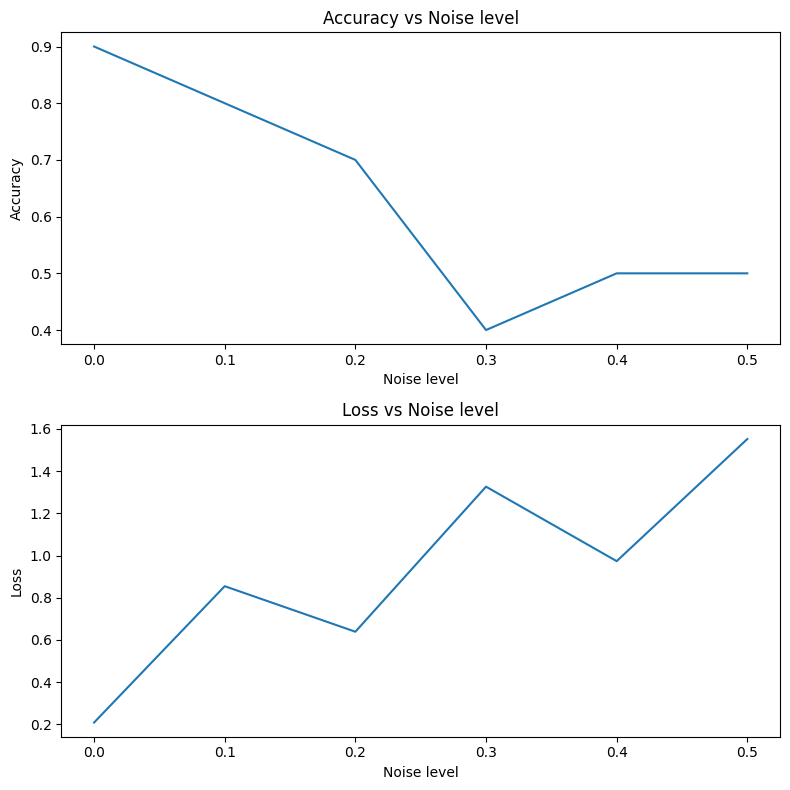

In [29]:
# Define a list of noise levels to iterate over
noise_levels = [0 , 0.1, 0.2, 0.3, 0.4, 0.5]

# Define an empty list to store the accuracies for each noise level
accuracies = []
losses = []

for noise in noise_levels:

    # Storing the obtained train and test data with added noise
    train_data , test_data = audio_data(mean_length, noise_level=noise)

    X_train = train_data['mfcc']
    y_train = train_data['labels']
    X_test = test_data['mfcc']
    y_test = test_data['labels']

    # Ensuring that all sequences in the dataset have the same length
    # Padding the sequences in X_train to a maximum length of 44
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=258)

    # Padding the sequences in X_test to a maximum length of 44
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=258)

    # preprocessing step where categorical labels are mapped to numerical values, so that they can be used as inputs to the model.
    mapping = {'Aditya':0,'Mehul':1 ,'Neha':2,'Saurabh':3,'Varad':4}   # creating a dictionary that maps class names to integers

    y_train = pd.DataFrame(y_train)    # converting y_train to a pandas dataframe
    y_train = y_train.replace(mapping)    # replacing the class names in y_train with their integer mappings
    y_train = np.array(y_train)    # converting y_train to a numpy array

    y_test = pd.DataFrame(y_test)    # converting y_test to a pandas dataframe
    y_test = y_test.replace(mapping)    # replacing the class names in y_test with their integer mappings
    y_test = np.array(y_test)    # converting y_test to a numpy array

    # Reshaping the training audio data to have 4 dimensions: batch size, audio samples, audio channels, and time steps
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

    # Getting the shape of the first audio clip in the training data
    input_shape = X_train[0].shape

    # Reshaping the testing audio data to have 4 dimensions: batch size, audio samples, audio channels, and time steps
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

    # Building the CNN model using the input shape
    model = build_model2(input_shape)

    # Defining the Adam optimizer with a learning rate of 0.001
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

    # Compiling the model with the Adam optimizer, sparse categorical crossentropy loss function, and accuracy metric
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Training the model on the training data using a batch size of 5, 30 epochs, and shuffling the data before each epoch
    history = model.fit(X_train, y_train, batch_size= 5 , epochs = 10 , shuffle = True)

    test_loss, test_acc = model.evaluate(X_test, y_test)

    accuracies.append(test_acc)
    losses.append(test_loss)

# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot the accuracy vs noise curve on the first subplot
axs[0].plot(noise_levels, accuracies)
axs[0].set_xlabel('Noise level')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Noise level')

# Plot the loss vs noise curve on the second subplot
axs[1].plot(noise_levels, losses)
axs[1].set_xlabel('Noise level')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss vs Noise level')

# Display the plot
plt.tight_layout()
plt.show()